In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu
from utils import ex2_helper as helper

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [39]:
def transformer(X):
        log_tranform_col = ['int_rate', 'annual_inc', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit']
        c_root_tranform_col = ['installment', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                            'total_il_high_credit_limit', 'total_bal_ex_mort', 'avg_cur_bal', 'bc_open_to_buy', 
                            'revol_bal', 'total_rec_int', 'last_pymnt_amnt', 'tot_coll_amt','tot_cur_bal']

        for col in c_root_tranform_col:
            X[col] = np.cbrt(X[col])
        for col in log_tranform_col:
            X[col] = np.log(X[col])
        return X

def train_test(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=40, stratify=y, test_size=0.2)
    X_te_id = X_te.pop('ID')
    X_tr_id = X_tr.pop('ID')
    return X_tr, X_te, y_tr, y_te, X_te_id, X_tr_id

In [40]:
data_path = r'data/loan-10k.lrn.csv'
df = pd.read_csv(data_path)

In [41]:
nn = NNFramework()
data = df.copy()

Define train and test splits:

In [42]:
y = data.pop('grade')
# X = data.pop('addr_state')
X = data
X = transformer(X)
cols = list(X.select_dtypes('object').columns)
nn.fit_encoder(X, cols)
X = nn.encode_dataset(X)
X_train, X_test, y_train, y_test, X_te_id, X_tr_id = train_test(X, y)

# Parameter experiments

## Running experiments

Define parameters:

In [43]:
random_seed = 1038
scaling = True
oversampling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [44]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

Run the experiments, save the experiment results to csv and pickle:

In [45]:
models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

df_param.to_csv(r'results/loan_experiments.csv', index=False)

with open(r'results/loan_lists_experiments.pickle', 'wb') as handle:
    pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [46]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

results_df.to_csv("results/loan_cancer_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 431...
Evaluation metrics:


array([[0.9532967 , 0.0467033 , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.078125  , 0.86458333, 0.05729167, 0.        , 0.        ,
        0.        , 0.        ],
       [0.00167224, 0.04347826, 0.89464883, 0.06020067, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.05172414, 0.84827586, 0.1       ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2016129 , 0.68548387,
        0.11290323, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.43243243,
        0.45945946, 0.10810811],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.72727273, 0.27272727]])

acc: 0.8655
balanced_acc: 0.7112107616121307

Macro-averaged precision: 0.7201077717644317
Macro-averaged recall: 0.7112107616121307
Macro-averaged f-score: 0.7126537754001301
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_6404\3234620560.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 90...
Evaluation metrics:


array([[0.92582418, 0.07417582, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.05555556, 0.87847222, 0.06597222, 0.        , 0.        ,
        0.        , 0.        ],
       [0.00167224, 0.04013378, 0.90301003, 0.05518395, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.1       , 0.83448276, 0.06551724,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.24193548, 0.62903226,
        0.12903226, 0.        ],
       [0.        , 0.        , 0.        , 0.02702703, 0.45945946,
        0.40540541, 0.10810811],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.81818182, 0.18181818]])

acc: 0.86
balanced_acc: 0.679720719342858

Macro-averaged precision: 0.6988947845740717
Macro-averaged recall: 0.679720719342858
Macro-averaged f-score: 0.685738971927923
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_6404\3234620560.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 20...
Evaluation metrics:


array([[0.89010989, 0.10989011, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.04513889, 0.87326389, 0.08159722, 0.        , 0.        ,
        0.        , 0.        ],
       [0.00167224, 0.05351171, 0.86956522, 0.0735786 , 0.        ,
        0.00167224, 0.        ],
       [0.        , 0.        , 0.11034483, 0.80344828, 0.0862069 ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.25806452, 0.56451613,
        0.17741935, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.51351351,
        0.43243243, 0.05405405],
       [0.        , 0.        , 0.        , 0.        , 0.18181818,
        0.81818182, 0.        ]])

acc: 0.833
balanced_acc: 0.6333336905309775

Macro-averaged precision: 0.6223999958498435
Macro-averaged recall: 0.6333336905309775
Macro-averaged f-score: 0.6267031789444483
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_6404\3234620560.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 77...
Evaluation metrics:


array([[0.86263736, 0.13736264, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03125   , 0.921875  , 0.04513889, 0.00173611, 0.        ,
        0.        , 0.        ],
       [0.00167224, 0.05183946, 0.84113712, 0.10535117, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.06896552, 0.74827586, 0.17931034,
        0.        , 0.00344828],
       [0.        , 0.        , 0.        , 0.21774194, 0.64516129,
        0.11290323, 0.02419355],
       [0.        , 0.        , 0.        , 0.        , 0.40540541,
        0.43243243, 0.16216216],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.63636364, 0.36363636]])

acc: 0.8325
balanced_acc: 0.6878793478347891

Macro-averaged precision: 0.6705301649705641
Macro-averaged recall: 0.6878793478347891
Macro-averaged f-score: 0.6772293088512661
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_6404\3234620560.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 107...
Evaluation metrics:


array([[0.91208791, 0.08791209, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.07118056, 0.83854167, 0.09027778, 0.        , 0.        ,
        0.        , 0.        ],
       [0.00167224, 0.04682274, 0.85953177, 0.09197324, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.1       , 0.78965517, 0.10689655,
        0.00344828, 0.        ],
       [0.        , 0.        , 0.        , 0.24193548, 0.58064516,
        0.16935484, 0.00806452],
       [0.        , 0.        , 0.        , 0.02702703, 0.37837838,
        0.54054054, 0.05405405],
       [0.        , 0.        , 0.        , 0.        , 0.18181818,
        0.45454545, 0.36363636]])

acc: 0.827
balanced_acc: 0.6978055127444069

Macro-averaged precision: 0.7100079247888319
Macro-averaged recall: 0.6978055127444069
Macro-averaged f-score: 0.6992778988256819
Macro-averaged support: None


C:\Users\Alina\AppData\Local\Temp\ipykernel_6404\3234620560.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


## Analysis

In [12]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['not_converged_num'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

In [13]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'not_converged_num']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [14]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [15]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [16]:
max_accuracies_ids = df_param[df_param.all_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [17]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

### Sigmoid vs RELU

In [18]:
def get_specific_table(model_lists_melted_df, col):
    df = model_lists_melted_df[(model_lists_melted_df.all_converged) & (model_lists_melted_df.metric_name.str.contains(col))]
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    both_models_converged = pd.DataFrame(df.groupby(['model_short', 'all_converged']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged = both_models_converged.drop('all_converged', axis=1)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')
    return df

#### Fitting times

In [19]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time')

C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\2176370425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')


[Text(0.5, 1.0, 'Mean fitting times over converged models'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'model')]

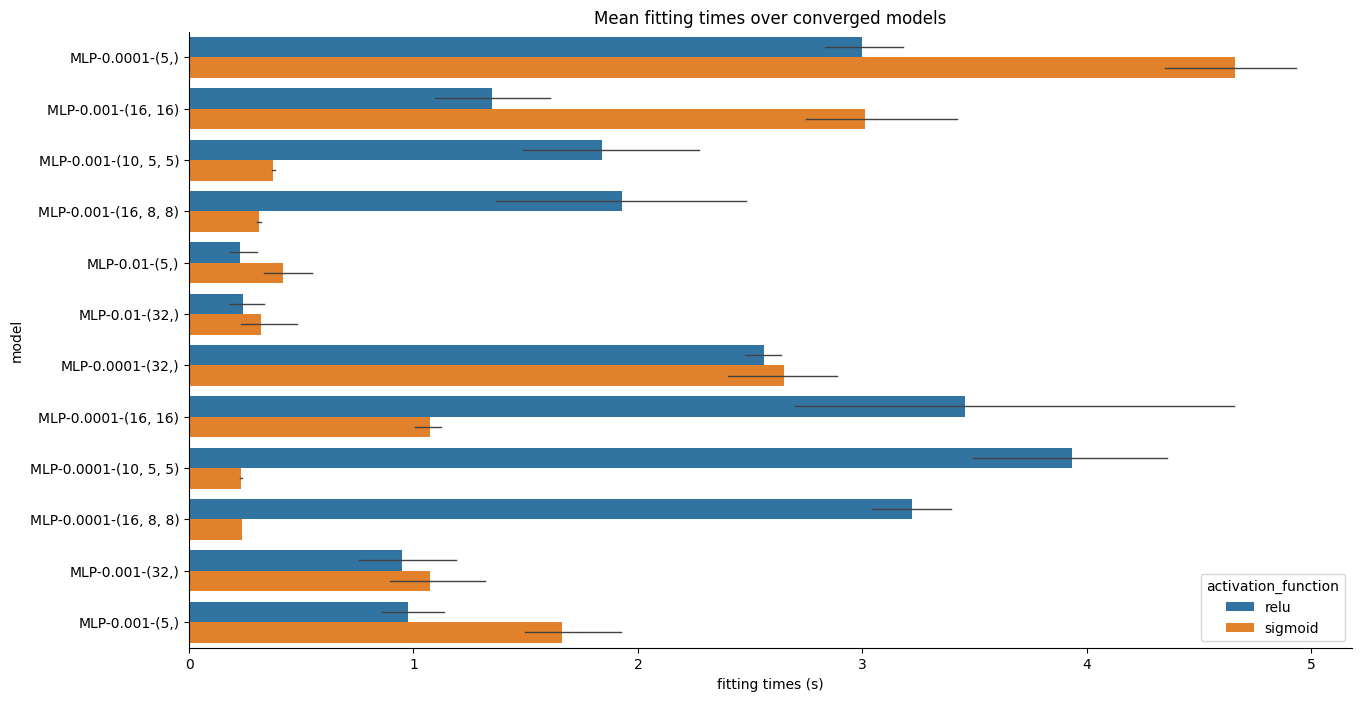

In [20]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model')

[Text(0.5, 1.0, 'Mean fitting times for best model in each architecture'),
 Text(0.5, 0, 'fitting times (s)'),
 Text(0, 0.5, 'layer size')]

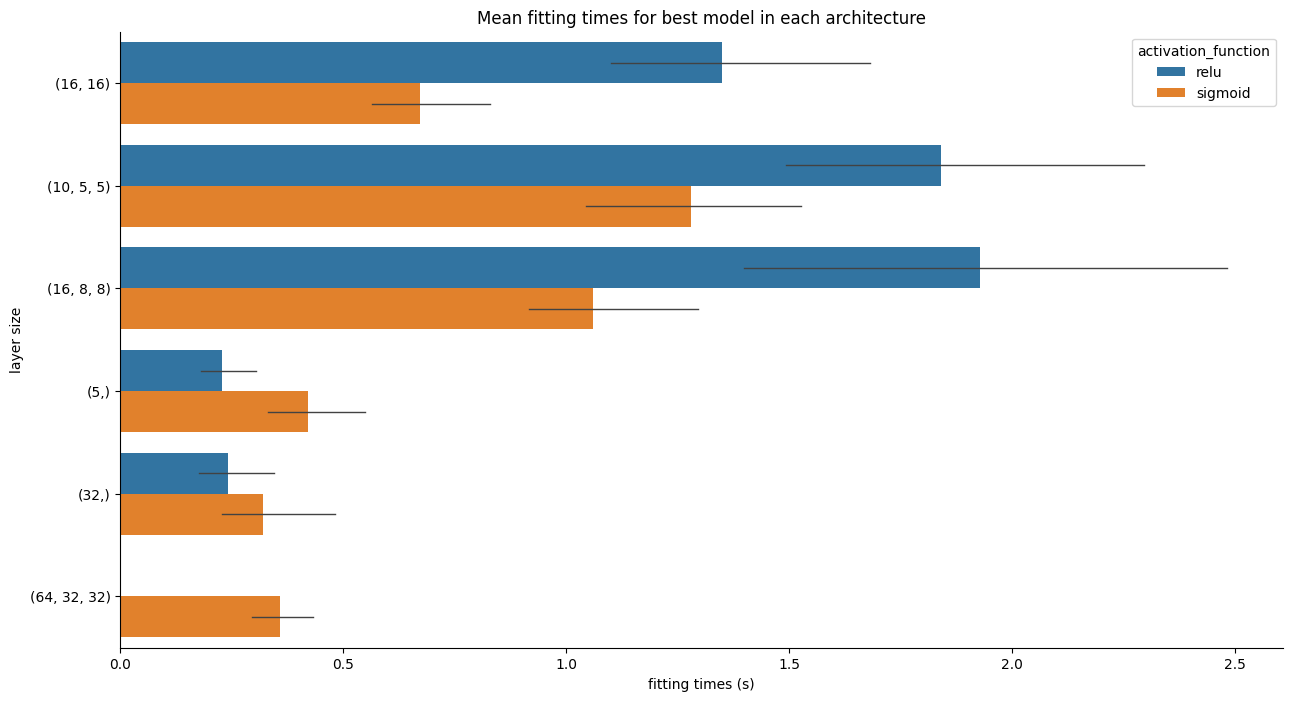

In [21]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
ax = sns.barplot(data=df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.values)], y='hidden_layer_sizes', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title=f'Mean fitting times for best model in each architecture', xlabel='fitting times (s)', ylabel='layer size')

#### Performance

In [22]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score')

C:\Users\Alina\AppData\Local\Temp\ipykernel_2280\2176370425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')


[Text(0.5, 1.0, 'Mean f1 scores over converged models'),
 Text(0.5, 0, 'f1 score'),
 Text(0, 0.5, 'model')]

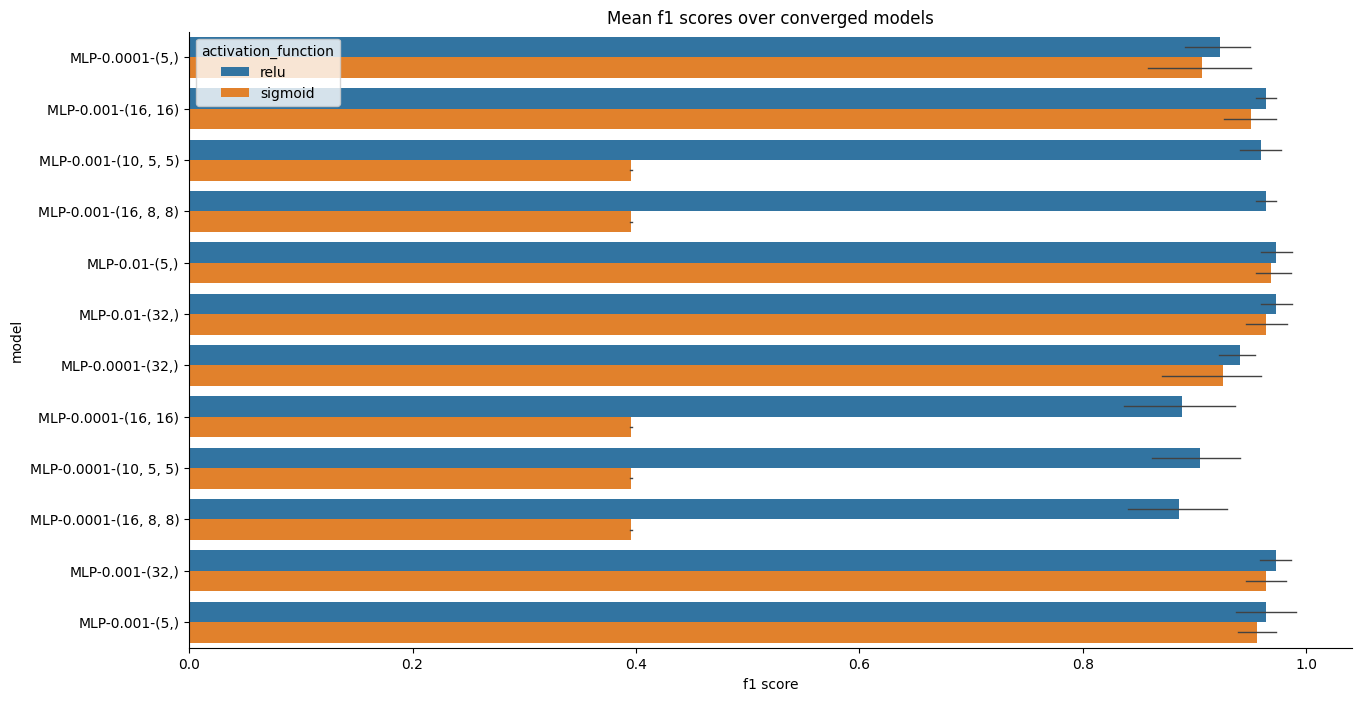

In [23]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model')

[Text(0.5, 1.0, 'Mean f1 scores for best model in each architecture'),
 Text(0.5, 0, 'f1 scores'),
 Text(0, 0.5, 'layer size')]

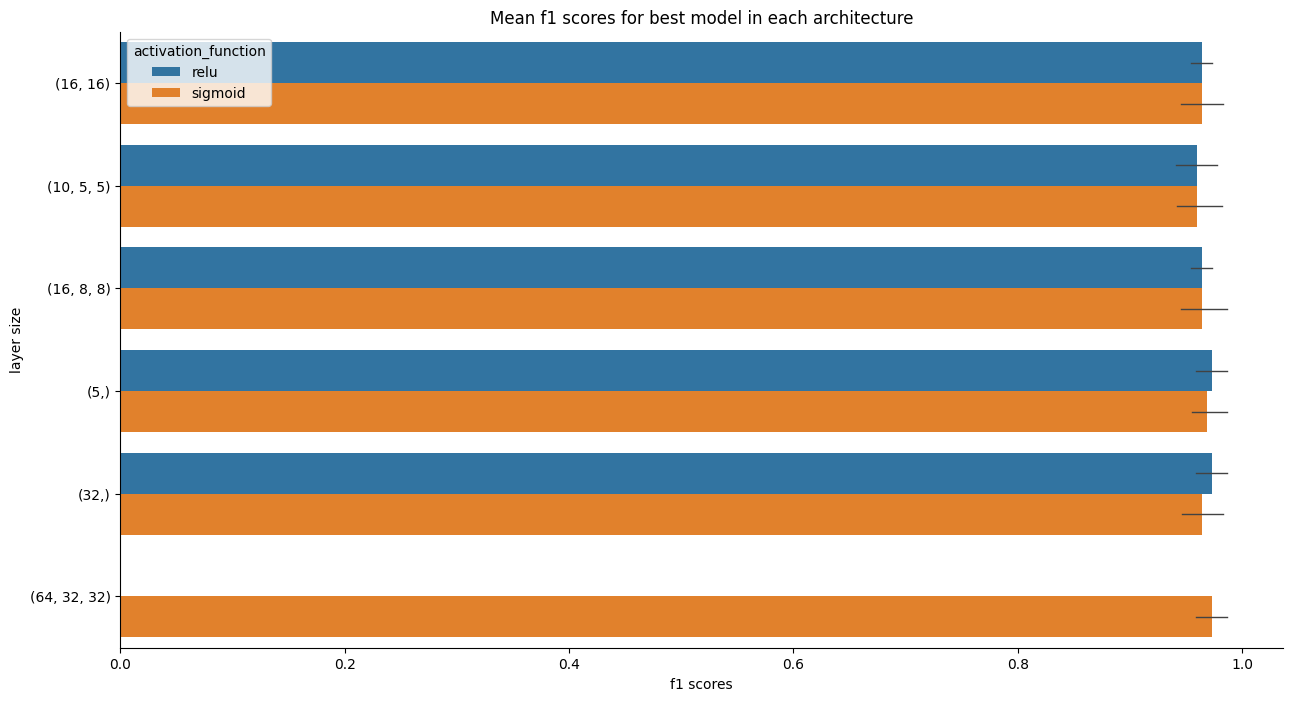

In [24]:
_, ax = plt.subplots(figsize=(15, 8))
sns.despine()
ax = sns.barplot(data=df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.values)], y='hidden_layer_sizes', x='metric_value', hue='activation_function', ax=ax, errwidth=1)
ax.set(title=f'Mean f1 scores for best model in each architecture', xlabel='f1 scores', ylabel='layer size')

#### Convergence and vanishing gradients

3 plots:
- relu vs sigmoid where both converged - Done
- best accuracy models for relu and for sigmoid; plot fitting times - Done
- convergence + vanishing gradients depending on learning rate, group by lr, agg total for lr

In [140]:
accuracy_threshold = df_param['test_score_mean'].max() * 0.3

In [167]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

In [171]:
vg_cols = [c for c in model_lists_df.columns if 'vanishing_gradients_' in c]

In [172]:
model_lists_df[vg_cols].values.tolist()

[[False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, Fal

In [ ]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

In [126]:
vg_f1_threshold = 0.4 
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = model_lists_df[model_lists_df[f'converged_cv{i}']][f'training_losses_cv{i}'].apply(lambda x: x[-1]/x[0] > vg_f1_threshold)
    model_lists_df[f'vanishing_gradients_cv{i}'] = model_lists_df[f'vanishing_gradients_cv{i}'].fillna(value=False) 

In [127]:
model_lists_df[model_lists_df[f'vanishing_gradients_cv{i}'] & ~model_lists_df[f'vanishing_gradients_cv{0}']][[f'vanishing_gradients_cv{i}', f'vanishing_gradients_cv{0}']]

,vanishing_gradients_cv4,vanishing_gradients_cv0
58,True,False


In [91]:
# model_lists_df[f'vanishing_gradients_cv{i}'] = model_lists_df[model_lists_df[f'converged_cv{i}']][f'training_losses_cv{i}'].apply(lambda x: x[-1]/x[0] > vg_f1_threshold)
# model_lists_df[f'vanishing_gradients_cv{i}'] = model_lists_df[f'vanishing_gradients_cv{i}'].fillna(value=False)

In [120]:
i

3

In [110]:
model_lists_df[f'test_score_cv{i}']

0     0.954963
1     0.954963
2     0.954963
3     0.954963
4     0.954963
5     0.791667
6     0.933333
7     0.977778
8     0.954963
9     0.977778
10    0.954963
11    0.395062
12    0.977778
13    0.977778
14    0.387500
15    0.752525
16    0.395062
17    0.395062
18    0.363636
19    0.424242
20    0.387500
21    0.752525
22    0.395062
23    0.395062
24    0.363636
25    0.424242
26    0.387500
27    0.752525
28    0.395062
29    0.395062
30    0.977156
31    0.954963
32    0.395062
33    0.395062
34    0.395062
35    0.395062
36    0.977778
37    0.956093
38    0.977778
39    0.395062
40    0.395062
41    0.977778
42    0.977778
43    0.956093
44    0.956093
45    0.956093
46    0.956093
47    0.956093
48    0.956093
49    0.956093
50    0.956093
51    0.956093
52    0.956093
53    0.977778
54    0.934869
55    0.934869
56    0.977778
57    0.954963
58    0.956093
59    0.257576
Name: test_score_cv3, dtype: float64

In [123]:
model_lists_df[model_lists_df[f'vanishing_gradients_cv{i}']][f'training_losses_cv{i}'].apply(lambda x: (x[0], x[-1]))

3     (0.6198695499954938, 0.29160615670020323)
4      (0.5853896838052629, 0.3487682996008439)
5        (0.87705020217038, 2.3855948643088256)
10     (0.6020815497717209, 0.4086747269523378)
32     (0.8555142705414284, 0.5861744504331519)
33     (0.6617201082050516, 0.6567834853735471)
34      (0.654788512445806, 0.6500122751199188)
35     (0.6507845342075462, 0.6488826169069676)
39      (0.6571004634865862, 0.638983826993199)
40     (0.6502643113150466, 0.6395359618680445)
59     (11.683289346987277, 11.958414358324047)
Name: training_losses_cv3, dtype: object

In [134]:
g_id = 5
i = 3
gradients = model_lists_df.loc[g_id, 'gradients'][i]
model_lists_df.loc[g_id, ['model', f'test_score_cv{i}']]

model             MLP-relu-0.0001-(64, 32, 32)
test_score_cv3                        0.791667
Name: 5, dtype: object

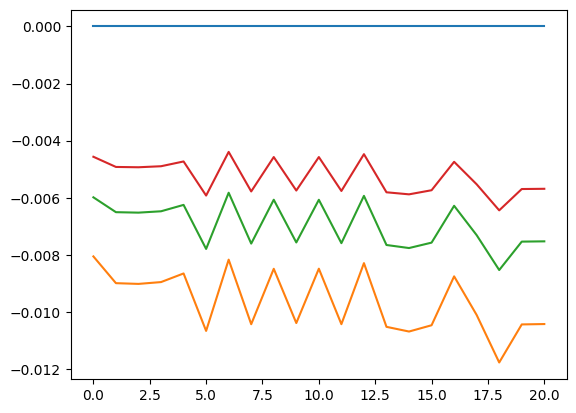

In [135]:
for i, grad in gradients.items():
    sns.lineplot(x=range(len(grad)), y=grad)

In [447]:
model_lists_df.loc[49, f'test_score_cv{i}']

0.43573667711598746

<Axes: >

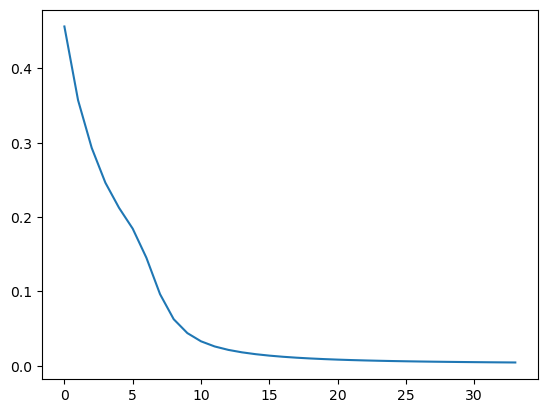

In [446]:
sns.lineplot(x=range(len(model_lists_df.loc[49, f'validation_losses_cv{i}'])), y=model_lists_df.loc[49, f'validation_losses_cv{i}'])

In [426]:
model_lists_df.groupby(['learning_rate', 'activation_function'])['not_converged_num', 'vanishing_gradient'].sum()

not_converged_num  vanishing_gradient
learning_rate activation_function                                       
0.0001        relu                                 0                   0
              sigmoid                              0                   0
0.0010        relu                                 2                   0
              sigmoid                              0                   0
0.0100        relu                                10                   0
              sigmoid                              0                   0
0.1000        relu                                29                   0
              sigmoid                              0                   0
0.5000        relu                                30                   0
              sigmoid                              0                   0

## Comparison 